2024-10-03 01:12:34,261 - INFO - Loading data for BTC
2024-10-03 01:12:34,273 - INFO - Loaded 2465 rows for BTC
2024-10-03 01:12:34,274 - INFO - Loading data for ETH
2024-10-03 01:12:34,286 - INFO - Loaded 2465 rows for ETH
2024-10-03 01:12:34,288 - INFO - Loading data for BNB
2024-10-03 01:12:34,303 - INFO - Loaded 2464 rows for BNB
2024-10-03 01:12:34,305 - INFO - Loading data for XRP
2024-10-03 01:12:34,318 - INFO - Loaded 2465 rows for XRP
2024-10-03 01:12:34,320 - INFO - Loading data for ADA
2024-10-03 01:12:34,332 - INFO - Loaded 2465 rows for ADA
2024-10-03 01:12:34,333 - INFO - Loading data for DOGE
2024-10-03 01:12:34,343 - INFO - Loaded 2465 rows for DOGE
2024-10-03 01:12:34,345 - INFO - Loading data for SOL
2024-10-03 01:12:34,353 - INFO - Loaded 1636 rows for SOL
2024-10-03 01:12:34,354 - INFO - Loading data for TON
2024-10-03 01:12:34,362 - INFO - Loaded 1131 rows for TON
2024-10-03 01:12:34,363 - INFO - Loading data for TRX
2024-10-03 01:12:34,374 - INFO - Loaded 2465 row

Sharpe Ratio: 0.8993
Beta: -0.0023
Alpha: 0.0041


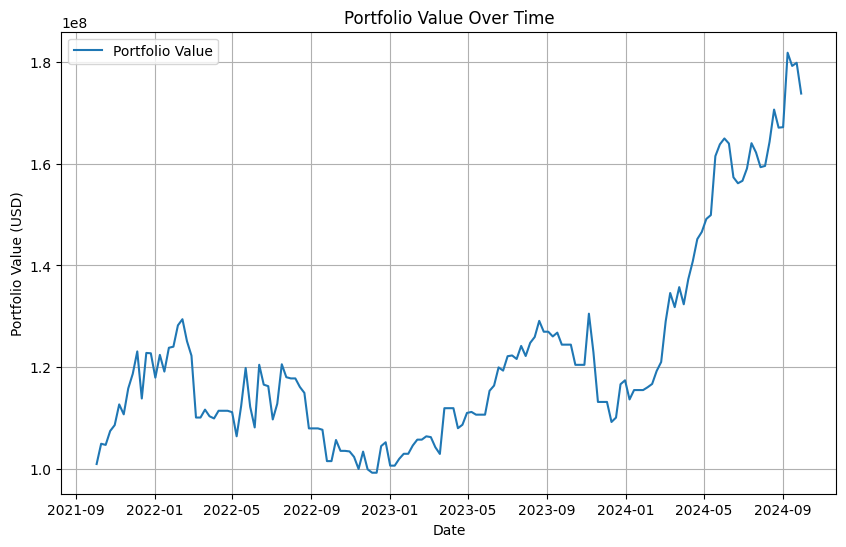

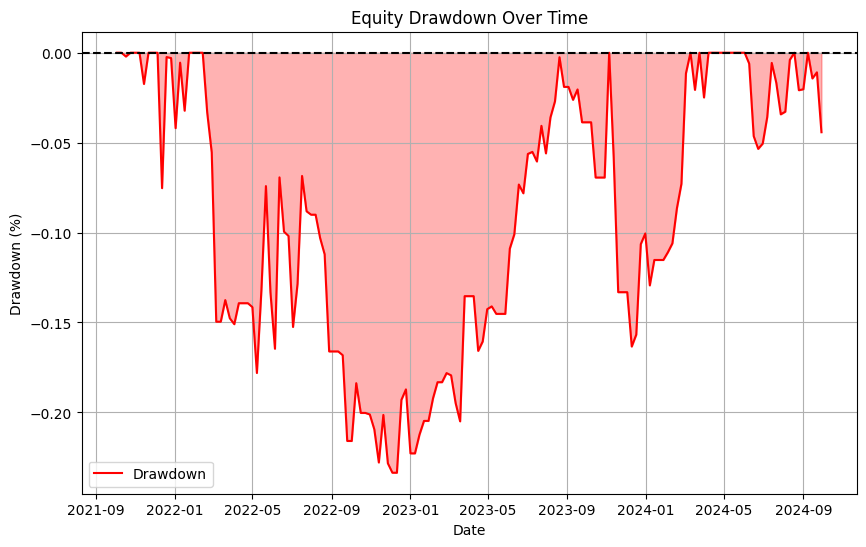

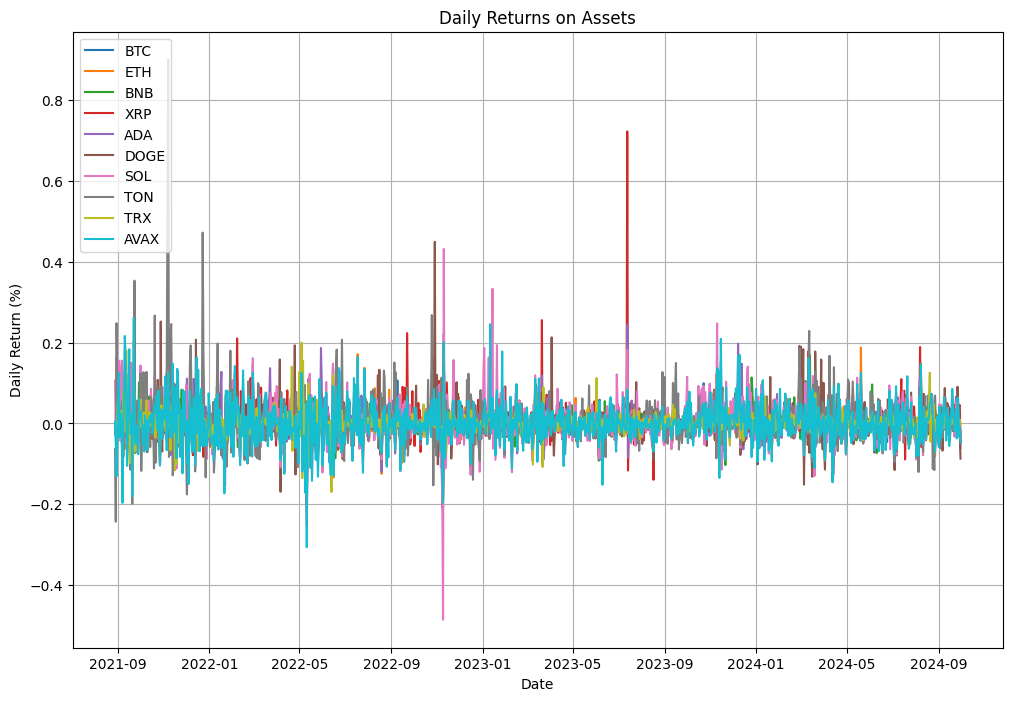

In [30]:
import pandas as pd
import numpy as np
import os
import logging
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS
import statsmodels.api as sm
import yfinance as yf

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Protection Strategy Functions
def adjust_hedge(long_return_total, short_return_average):
    """
    Adjust hedge ratio based on long and short returns.

    Parameters:
    - long_return_total (float): Total return from long positions.
    - short_return_average (float): Average return from short positions.

    Returns:
    - hedge_ratio (float): Proportion of the portfolio to hedge.
    """
    if long_return_total < short_return_average:
        return 0.35  # Adjust this value as needed
    else:
        return 0.0


def protection_strategy_sp(weekly_return, long_return_total, short_return_average):
    """
    Stop Protection (SP) strategy to adjust weekly returns based on hedge ratio.

    Parameters:
    - weekly_return (float): Original weekly return.
    - long_return_total (float): Total return from long positions.
    - short_return_average (float): Average return from short positions.

    Returns:
    - adjusted_weekly_return (float): Adjusted weekly return after applying SP.
    """
    hedge_ratio = adjust_hedge(long_return_total, short_return_average)
    adjusted_weekly_return = long_return_total * (1 - hedge_ratio) - short_return_average
    logging.info(f"SP Strategy Applied: Hedge Ratio = {hedge_ratio}, Adjusted Weekly Return = {adjusted_weekly_return:.4f}")
    return adjusted_weekly_return


def protection_strategy_cppi(portfolio_value, floor, multiplier, weekly_return):
    """
    Constant Proportion Portfolio Insurance (CPPI) strategy implementation.

    Parameters:
    - portfolio_value (float): Current portfolio value.
    - floor (float): Minimum acceptable portfolio value.
    - multiplier (float): Determines the exposure to risky assets.
    - weekly_return (float): Original weekly return.

    Returns:
    - adjusted_weekly_return (float): Adjusted weekly return after applying CPPI.
    """
    # Calculate the cushion
    cushion = portfolio_value - floor

    # Determine exposure to risky assets
    investment_risky = cushion * multiplier
    investment_risky = min(investment_risky, portfolio_value)  # Ensure not to exceed portfolio

    # Allocation to safe assets
    investment_safe = portfolio_value - investment_risky

    # Calculate returns
    # Assuming weekly_return represents the return from risky assets
    risky_return = investment_risky * weekly_return
    safe_return = investment_safe * 0.0  # Assuming safe assets have 0% return

    # Total adjusted return
    adjusted_weekly_return = (risky_return + safe_return) / portfolio_value
    logging.info(f"CPPI Strategy Applied: Cushion = {cushion:.2f}, Investment Risky = {investment_risky:.2f}, "
                 f"Investment Safe = {investment_safe:.2f}, Adjusted Weekly Return = {adjusted_weekly_return:.4f}")
    return adjusted_weekly_return


def protection_strategy_tipp(weekly_return, long_return_total, short_return_average, base_allocation=0.5):
    """
    Time-Invariant Portfolio Protection (TIPP) strategy implementation.

    Parameters:
    - weekly_return (float): Original weekly return.
    - long_return_total (float): Total return from long positions.
    - short_return_average (float): Average return from short positions.
    - base_allocation (float): Fixed allocation to risky assets.

    Returns:
    - adjusted_weekly_return (float): Adjusted weekly return after applying TIPP.
    """
    # TIPP maintains a fixed allocation to risky assets regardless of performance
    # base_allocation determines the proportion allocated to risky assets
    investment_risky = base_allocation
    investment_safe = 1 - base_allocation

    adjusted_weekly_return = (investment_risky * weekly_return) + (investment_safe * 0.0)  # Safe assets have 0% return
    logging.info(f"TIPP Strategy Applied: Investment Risky = {investment_risky:.2f}, "
                 f"Investment Safe = {investment_safe:.2f}, Adjusted Weekly Return = {adjusted_weekly_return:.4f}")
    return adjusted_weekly_return


def protection_strategy_vbpi(portfolio_value, volatility, threshold=0.05, base_allocation=0.5, max_allocation=1.0, min_allocation=0.0):
    """
    Volatility-Based Portfolio Insurance (VBPI) strategy implementation.

    Parameters:
    - portfolio_value (float): Current portfolio value.
    - volatility (float): Current market volatility (e.g., standard deviation of returns).
    - threshold (float): Volatility threshold to adjust allocations.
    - base_allocation (float): Base allocation to risky assets at normal volatility.
    - max_allocation (float): Maximum allocation to risky assets during low volatility.
    - min_allocation (float): Minimum allocation to risky assets during high volatility.

    Returns:
    - adjusted_weekly_return (float): Adjusted weekly return after applying VBPI.
    """
    # Adjust allocation based on volatility
    if volatility > threshold:
        # High volatility: reduce exposure to risky assets
        allocation_risky = min_allocation
    else:
        # Low or normal volatility: increase exposure to risky assets
        allocation_risky = min(base_allocation + (threshold - volatility), max_allocation)
    
    allocation_safe = 1 - allocation_risky

    # For VBPI, we might need a return based on allocation
    adjusted_weekly_return = (allocation_risky * weekly_return) + (allocation_safe * 0.0)  # Safe assets have 0% return
    logging.info(f"VBPI Strategy Applied: Allocation Risky = {allocation_risky:.2f}, "
                 f"Allocation Safe = {allocation_safe:.2f}, Adjusted Weekly Return = {adjusted_weekly_return:.4f}")
    return adjusted_weekly_return


# Rebalancing Function
def rebalancing(portfolio, target_allocation):
    """
    Rebalance the portfolio to match the target allocation.

    Parameters:
    - portfolio (dict): Current portfolio with asset allocations.
    - target_allocation (dict): Target allocation percentages.

    Returns:
    - portfolio (dict): Rebalanced portfolio.
    """
    total_value = sum(portfolio.values())
    for asset, allocation in target_allocation.items():
        portfolio[asset] = total_value * allocation
    logging.info(f"Portfolio rebalanced: {portfolio}")
    return portfolio


# Load Price and Market Cap Data
def load_price_and_market_cap_data(folder_path, coins, start_date, end_date):
    """
    Load price and market cap data from CSV files.

    Parameters:
    - folder_path (str): Path to CSV files.
    - coins (list): List of cryptocurrency symbols.
    - start_date (str): Start date for the data.
    - end_date (str): End date for the data.

    Returns:
    - price_data (pd.DataFrame): DataFrame of close prices.
    - market_cap_data (dict): Dictionary of market cap and volume data.
    """
    price_data = {}
    market_cap_data = {}

    for coin in coins:
        logging.info(f"Loading data for {coin}")
        file_path = os.path.join(folder_path, f"{coin}.csv")
        if not os.path.exists(file_path):
            logging.error(f"File not found: {file_path}")
            continue
        df = pd.read_csv(file_path, parse_dates=['Start'], index_col='Start')

        # Log the number of loaded rows for this coin
        logging.info(f"Loaded {len(df)} rows for {coin}")

        # Store close prices for price data
        price_data[coin] = df['Close']

        # Store market cap data
        market_cap_data[coin] = df[['Market Cap', 'Volume']]

    # Convert dictionaries to DataFrames
    price_data = pd.DataFrame(price_data)

    # Handle missing values in price data (forward fill or drop)
    logging.info("Forward filling and dropping NaN values in the price data.")
    price_data.ffill(inplace=True)  # Forward fill missing values
    price_data.dropna(inplace=True)  # Drop rows with persistent NaN values

    # Log the date range of the price data
    logging.info(f"Price Data Date Range: {price_data.index.min()} to {price_data.index.max()}")

    # Check if we have data for the required backtest period
    if price_data.index.min() > pd.to_datetime(start_date) or price_data.index.max() < pd.to_datetime(end_date):
        logging.warning(f"Price data does not cover the full backtest period from {start_date} to {end_date}")

    # Convert market_cap_data to proper DataFrames
    market_cap_data = {coin: df for coin, df in market_cap_data.items()}

    logging.info(f"Price Data Head:\n{price_data.head()}")
    return price_data, market_cap_data


# Factor Calculation
def calculate_factors(price_data, cap_data, rolling_window=7):
    """
    Calculate Momentum, Size, and Value factors.

    Parameters:
    - price_data (pd.DataFrame): DataFrame of close prices.
    - cap_data (dict): Dictionary of market cap and volume data.
    - rolling_window (int): Rolling window for momentum calculation.

    Returns:
    - momentum (pd.DataFrame): Momentum factor.
    - size (pd.DataFrame): Size factor (market cap).
    - value (pd.DataFrame): Value factor (inverse of NVT ratio).
    """
    logging.info("Calculating factors (Momentum, Size, Value)")

    # Momentum: past week return
    momentum = price_data.pct_change(rolling_window).shift(1)
    logging.info(f"Momentum head:\n{momentum.head()}")

    # Size: market cap of the coins
    size = pd.DataFrame({coin: cap_data[coin]['Market Cap'] for coin in cap_data})
    logging.info(f"Size head:\n{size.head()}")

    # Value: inverse of NVT ratio (Market Cap / Volume)
    value = pd.DataFrame({coin: cap_data[coin]['Market Cap'] / cap_data[coin]['Volume'] for coin in cap_data})

    # Handle potential divide-by-zero or inf values in NVT ratio
    value.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN
    value.fillna(0, inplace=True)  # Replace NaN values with 0 or another strategy
    logging.info(f"Value (NVT) head before inversion:\n{value.head()}")

    value = 1 / value
    value = value.clip(lower=-1e9, upper=1e9)  # Clip values to a reasonable range
    logging.info(f"Value (after inversion and clipping) head:\n{value.head()}")

    return momentum, size, value


# Backtest Strategy
def backtest_strategy(start_date, end_date, initial_investment, price_data, cap_data, 
                     protection_strategy, 
                     floor_ratio=0.9, 
                     multiplier=3, 
                     threshold=0.05, 
                     base_allocation_tipp=0.5, 
                     max_allocation_vbpi=1.0, 
                     min_allocation_vbpi=0.0,
                     rebalance_time='00:00'):
    """
    Backtest the crypto strategy with dynamic long/short and protection strategy.

    Parameters:
    - start_date (str): Start date of the backtest in 'YYYY-MM-DD' format.
    - end_date (str): End date of the backtest in 'YYYY-MM-DD' format.
    - initial_investment (float): Initial portfolio value in USD.
    - price_data (pd.DataFrame): DataFrame of close prices.
    - cap_data (dict): Dictionary of market cap and volume data.
    - protection_strategy (function): Function to apply protection strategy.
    - floor_ratio (float): Ratio to determine the floor (e.g., 0.9 for 90% of initial investment).
    - multiplier (float): Multiplier for CPPI strategy.
    - threshold (float): Volatility threshold for VBPI strategy.
    - base_allocation_tipp (float): Base allocation for TIPP strategy.
    - max_allocation_vbpi (float): Max allocation to risky assets for VBPI.
    - min_allocation_vbpi (float): Min allocation to risky assets for VBPI.
    - rebalance_time (str): Time of day to perform rebalancing.

    Returns:
    - portfolio_history_df (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    - returns_history (list): List of weekly returns.
    """
    logging.info("Starting backtest")
    # Initialize portfolio metrics
    portfolio_value = initial_investment
    portfolio_history = []
    returns_history = []

    dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
    logging.info(f"Backtest dates: {dates}")

    # Calculate floor based on initial investment
    floor = initial_investment * floor_ratio

    # Calculate factors
    momentum, size, value = calculate_factors(price_data, cap_data)

    # Standardize factors (handle NaN and inf values)
    scaler = StandardScaler()

    # Apply StandardScaler while handling NaN values
    logging.info("Standardizing factors.")
    momentum_std = pd.DataFrame(scaler.fit_transform(momentum.fillna(0)), index=momentum.index, columns=momentum.columns)
    size_std = pd.DataFrame(scaler.fit_transform(size.fillna(0)), index=size.index, columns=size.columns)
    value_std = pd.DataFrame(scaler.fit_transform(value.fillna(0)), index=value.index, columns=value.columns)

    # Combine factors (equal weight)
    combined_signal = (momentum_std + size_std + value_std) / 3
    logging.info(f"Combined signal head:\n{combined_signal.head()}")

    # Restrict signals to the backtest period (starting from start_date)
    combined_signal = combined_signal.loc[start_date:end_date]

    for date in dates:
        # Use only the date without time
        portfolio_date = date
        logging.info(f"Rebalancing for date: {portfolio_date.date()}")

        if portfolio_date in combined_signal.index:
            signals = combined_signal.loc[portfolio_date]
            logging.info(f"Signals on {portfolio_date.date()}:\n{signals}")

            # Check if there are any valid signals
            if signals.isna().all():
                logging.warning(f"No valid signals on {portfolio_date.date()}. Skipping this date.")
                # Append current portfolio value and zero return
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue

            # Split signals dynamically based on their strength
            long_threshold = 0.5  # Go long if signal > 0.5
            short_threshold = -0.5  # Go short if signal < -0.5

            # Dynamic long/short allocation based on signal strength
            long_coins = signals[signals > long_threshold].index
            short_coins = signals[signals < short_threshold].index

            # If no strong short signals, skip shorting
            if len(short_coins) == 0:
                logging.info(f"No strong short signals on {portfolio_date.date()}. Not shorting.")

            # If no strong long signals, skip longing
            if len(long_coins) == 0:
                logging.info(f"No strong long signals on {portfolio_date.date()}. Not longing.")

            # Ensure there are coins to long or short
            if len(long_coins) == 0 and len(short_coins) == 0:
                logging.warning(f"No strong signals to act upon on {portfolio_date.date()}. Skipping.")
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue

            # Compute value-weighted allocation
            total_market_cap = size.loc[portfolio_date, long_coins].sum() if len(long_coins) > 0 else 1
            weights = size.loc[portfolio_date, long_coins] / total_market_cap if len(long_coins) > 0 else pd.Series(0, index=long_coins)

            # Log market cap and weights for long positions
            logging.info(f"Market cap for long coins:\n{size.loc[portfolio_date, long_coins]}")
            logging.info(f"Weights for long positions:\n{weights}")

            try:
                # Find the next trading day after portfolio_date
                future_dates = price_data.index[price_data.index > portfolio_date]
                if future_dates.empty:
                    logging.warning(f"No future price data available after {portfolio_date.date()}. Skipping return calculation.")
                    portfolio_history.append(portfolio_value)
                    returns_history.append(0.0)
                    continue
                next_date = future_dates[0]

                # Ensure next_date is within the price_data index
                if next_date not in price_data.index:
                    logging.warning(f"No price data for the next day after {portfolio_date.date()}. Skipping return calculation.")
                    portfolio_history.append(portfolio_value)
                    returns_history.append(0.0)
                    continue

                # Calculate long returns
                long_price_current = price_data.loc[portfolio_date, long_coins]
                long_price_next = price_data.loc[next_date, long_coins]
                long_returns = (long_price_next / long_price_current - 1) * weights
                long_return_total = long_returns.sum()

                # Calculate short returns
                short_return_total = 0.0
                if len(short_coins) > 0:
                    short_price_current = price_data.loc[portfolio_date, short_coins]
                    short_price_next = price_data.loc[next_date, short_coins]
                    short_returns = (short_price_next / short_price_current - 1)
                    short_return_total = short_returns.mean() if not short_returns.empty else 0.0

            except Exception as e:
                logging.error(f"Error calculating returns: {e}")
                portfolio_history.append(portfolio_value)
                returns_history.append(0.0)
                continue

            # Calculate original weekly return
            original_weekly_return = long_return_total - short_return_total
            logging.info(f"Original Weekly Return: {original_weekly_return:.4f}")

            # Apply protection strategy
            if protection_strategy.__name__ == 'protection_strategy_cppi':
                adjusted_weekly_return = protection_strategy(
                    portfolio_value, floor, multiplier, original_weekly_return
                )
            elif protection_strategy.__name__ == 'protection_strategy_vbpi':
                # Calculate volatility (e.g., standard deviation of past 4 weeks' returns)
                window_volatility = 4
                if len(returns_history) >= window_volatility:
                    recent_returns = returns_history[-window_volatility:]
                    volatility = np.std(recent_returns)
                else:
                    volatility = 0.0  # Assume low volatility if not enough data
                adjusted_weekly_return = protection_strategy(
                    portfolio_value, volatility, threshold, 
                    base_allocation=0.5,  # base_allocation can be parameterized as needed
                    max_allocation=max_allocation_vbpi,
                    min_allocation=min_allocation_vbpi
                )
            elif protection_strategy.__name__ == 'protection_strategy_tipp':
                adjusted_weekly_return = protection_strategy(
                    original_weekly_return, long_return_total, short_return_total, 
                    base_allocation=base_allocation_tipp
                )
            else:
                # Default to SP if unknown strategy
                adjusted_weekly_return = protection_strategy(original_weekly_return, long_return_total, short_return_total)

            # Update portfolio value
            portfolio_value *= (1 + adjusted_weekly_return)

            logging.info(f"Adjusted Weekly Return: {adjusted_weekly_return:.4f}")
            logging.info(f"Updated portfolio value: {portfolio_value:.2f}")

            # Record portfolio history
            portfolio_history.append(portfolio_value)
            returns_history.append(adjusted_weekly_return)
        else:
            logging.warning(f"No signal data for {portfolio_date.date()}. Skipping.")
            portfolio_history.append(portfolio_value)
            returns_history.append(0.0)

    # Convert history to DataFrame
    if portfolio_history:
        portfolio_history_df = pd.DataFrame(portfolio_history, index=dates, columns=['Portfolio Value'])
    else:
        logging.warning("No portfolio history recorded.")
        portfolio_history_df = pd.DataFrame(columns=['Portfolio Value'], index=dates)

    return portfolio_history_df, returns_history


# Performance Metrics
def calculate_metrics(portfolio_history, returns_history, start_date, end_date):
    """
    Calculate Sharpe Ratio, Beta, and Alpha for the backtested portfolio.

    Parameters:
    - portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    - returns_history (list): List of weekly returns.
    - start_date (str): Start date of the backtest in 'YYYY-MM-DD' format.
    - end_date (str): End date of the backtest in 'YYYY-MM-DD' format.

    Returns:
    - sharpe_ratio (float): Annualized Sharpe Ratio.
    - beta (float): Beta of the portfolio relative to BTC.
    - alpha (float): Alpha of the portfolio.
    """
    # Convert returns_history to a pandas Series with backtest dates as index
    backtest_dates = pd.date_range(start=start_date, end=end_date, freq='W-SUN')
    returns_series = pd.Series(returns_history, index=backtest_dates)
    logging.info(f"Backtest dates index for returns_series:\n{returns_series.index}")

    # Calculate Sharpe Ratio
    returns_cleaned = returns_series.dropna()  # Drop NaN values
    logging.info(f"Cleaned returns history: {returns_cleaned}")

    if len(returns_cleaned) == 0:
        logging.warning("No returns to calculate metrics.")
        return np.nan, np.nan, np.nan

    sharpe_ratio = np.mean(returns_cleaned) / np.std(returns_cleaned) * np.sqrt(52)  # Annualized Sharpe Ratio (52 weeks)

    # Fetch BTC data using yfinance
    btc_ticker = 'BTC-USD'
    logging.info(f"Fetching BTC data from {start_date} to {end_date} using yfinance.")

    try:
        btc_data = yf.download(btc_ticker, start=start_date, end=end_date, progress=False)
    except Exception as e:
        logging.error(f"Error fetching BTC data: {e}")
        return sharpe_ratio, np.nan, np.nan

    if btc_data.empty:
        logging.error("Fetched BTC data is empty. Please check the ticker and date range.")
        return sharpe_ratio, np.nan, np.nan

    # Ensure the data is sorted in ascending order
    btc_data.sort_index(inplace=True)
    logging.info("Sorted BTC data in ascending order.")

    # Calculate daily returns
    market_returns_daily = btc_data['Close'].pct_change().dropna()

    # Resample daily market returns to weekly returns (W-SUN) by compounding
    market_returns_weekly = market_returns_daily.resample('W-SUN').agg(lambda x: (1 + x).prod() - 1)
    logging.info(f"Weekly market returns from {start_date} to {end_date}:\n{market_returns_weekly.head()}")

    # Align the indices of returns_history and market_returns_weekly using common dates
    common_dates = returns_series.index.intersection(market_returns_weekly.index)
    aligned_returns_history = returns_series.loc[common_dates]
    aligned_market_returns = market_returns_weekly.loc[common_dates]

    logging.info(f"Common dates after intersection: {common_dates}")
    logging.info(f"Aligned returns history after intersect:\n{aligned_returns_history}")
    logging.info(f"Aligned market returns after intersect:\n{aligned_market_returns}")

    # Ensure both series have no NaN values
    aligned_returns_history = aligned_returns_history.dropna()
    aligned_market_returns = aligned_market_returns.dropna()

    # Re-align indices to ensure they match exactly
    common_dates_final = aligned_returns_history.index.intersection(aligned_market_returns.index)
    aligned_returns_history = aligned_returns_history.loc[common_dates_final]
    aligned_market_returns = market_returns_weekly.loc[common_dates_final]

    logging.info(f"Final common dates after re-intersection: {common_dates_final}")
    logging.info(f"Final aligned returns history:\n{aligned_returns_history}")
    logging.info(f"Final aligned market returns:\n{aligned_market_returns}")

    # Check if we have enough data to run the regression
    if len(aligned_returns_history) < 2:
        logging.warning("Not enough data for regression.")
        return sharpe_ratio, np.nan, np.nan

    # Convert data to float to avoid dtype issues
    aligned_returns_history = aligned_returns_history.astype(float)
    aligned_market_returns = aligned_market_returns.astype(float)

    # Calculate Beta and Alpha using OLS regression
    X = sm.add_constant(aligned_market_returns)  # Adds a constant term to the predictor
    model = OLS(aligned_returns_history, X).fit()
    beta = model.params[aligned_market_returns.name]
    alpha = model.params['const']

    # Optionally, log the regression summary for debugging
    logging.debug(model.summary())

    return sharpe_ratio, beta, alpha


# Plot Portfolio
def plot_portfolio(portfolio_history):
    """
    Plot the portfolio value over time.

    Parameters:
    - portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Equity Drawdown Calculation and Plot
def plot_equity_drawdown(portfolio_history):
    """
    Plot the equity drawdown over time.

    Parameters:
    - portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    """
    portfolio_history['Max Value'] = portfolio_history['Portfolio Value'].cummax()
    portfolio_history['Drawdown'] = (portfolio_history['Portfolio Value'] - portfolio_history['Max Value']) / portfolio_history['Max Value']

    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Drawdown'], label='Drawdown', color='red')
    plt.fill_between(portfolio_history.index, portfolio_history['Drawdown'], color='red', alpha=0.3)
    plt.title('Equity Drawdown Over Time')
    plt.xlabel('Date')
    plt.ylabel('Drawdown (%)')
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(True)
    plt.legend()
    plt.show()


# Daily Returns on Assets Calculation and Plot
def plot_daily_returns_on_assets(price_data):
    """
    Plot the daily returns on assets over time.

    Parameters:
    - price_data (pd.DataFrame): DataFrame containing historical prices for each cryptocurrency indexed by date.
    """
    daily_returns = price_data.pct_change().dropna()  # Calculate daily returns
    plt.figure(figsize=(12, 8))
    plt.plot(daily_returns.index, daily_returns)
    plt.title('Daily Returns on Assets')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.grid(True)
    plt.legend(price_data.columns, loc='upper left')
    plt.show()


# Plot Portfolio Value with Drawdown and Daily Returns
def plot_portfolio_and_drawdown(portfolio_history, price_data):
    """
    Plot both the portfolio value and the equity drawdown over time.

    Parameters:
    - portfolio_history (pd.DataFrame): DataFrame containing portfolio values indexed by date.
    - price_data (pd.DataFrame): DataFrame containing historical prices for each cryptocurrency.
    """
    # Plot portfolio value over time
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history.index, portfolio_history['Portfolio Value'], label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot equity drawdown
    plot_equity_drawdown(portfolio_history)

    # Plot daily returns on assets
    plot_daily_returns_on_assets(price_data)


# Main Execution
def main():
    # Parameters
    start_date = "2021-10-01"
    end_date = "2024-09-29"  # Ensure yfinance has data up to this date
    initial_investment = 100_000_000  # 100M USD

    # Load data for top 10 cryptocurrencies (excluding USDT and USDC)
    top_10_coins = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TON', 'TRX', 'AVAX']
    folder_path = 'Data'  # Path to CSV files containing market cap data

    # Load price and market cap data from CSV files
    price_data, market_cap_data = load_price_and_market_cap_data(folder_path, top_10_coins, start_date, end_date)

    # Select Protection Strategy
    # Options: protection_strategy_sp, protection_strategy_cppi, protection_strategy_tipp, protection_strategy_vbpi
    # Uncomment the strategy you want to test:

    protection_strategy = protection_strategy_sp  # Stop Protection
    #protection_strategy = protection_strategy_cppi  # CPPI Strategy
    #protection_strategy = protection_strategy_tipp  # TIPP Strategy
    # protection_strategy = protection_strategy_vbpi  # VBPI Strategy

    # Define CPPI Parameters (only relevant if CPPI is selected)
    floor_ratio = 0.9  # 90% floor
    multiplier = 3  # CPPI multiplier

    # Define VBPI Parameters (only relevant if VBPI is selected)
    threshold = 0.1  # Volatility threshold
    base_allocation_vbpi = 0.5  # Base allocation to risky assets
    max_allocation_vbpi = 1.0  # Max allocation to risky assets
    min_allocation_vbpi = 0.0  # Min allocation to risky assets

    # Define TIPP Parameters (only relevant if TIPP is selected)
    base_allocation_tipp = 0.75  # Fixed allocation to risky assets

    # Backtest the strategy
    portfolio_history, returns_history = backtest_strategy(
        start_date, 
        end_date, 
        initial_investment, 
        price_data, 
        market_cap_data, 
        protection_strategy,
        floor_ratio=floor_ratio,
        multiplier=multiplier,
        threshold=threshold,
        base_allocation_tipp=base_allocation_tipp,
        max_allocation_vbpi=max_allocation_vbpi,
        min_allocation_vbpi=min_allocation_vbpi
    )

    # Calculate performance metrics
    sharpe_ratio, beta, alpha = calculate_metrics(portfolio_history, returns_history, start_date, end_date)
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Beta: {beta:.4f}")
    print(f"Alpha: {alpha:.4f}")

    # Plot portfolio value, equity drawdown, and daily returns on assets
    plot_portfolio_and_drawdown(portfolio_history, price_data)


if __name__ == "__main__":
    main()